In [20]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

## Set-up

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

import sys
# sys.path.append('/homes/chunchieh/brain/sam2/notebooks')
os.chdir('/homes/chunchieh/brain/sam2/notebooks')

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

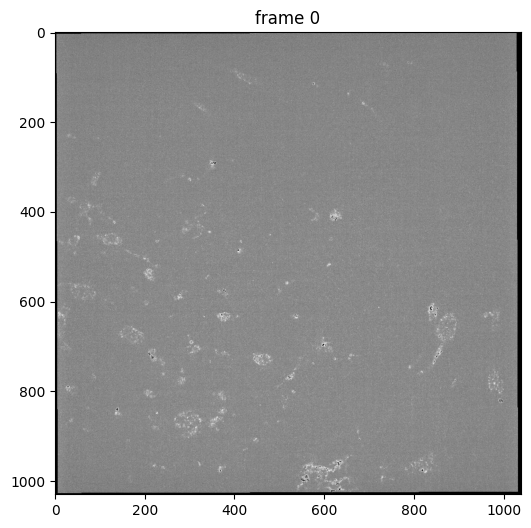

In [7]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/homes/chunchieh/brain/data_jpeg/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F017/raw_data_1000_1500_frame"
init_slice = 1000
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# try 1695 to 2741
# frame_names = frame_names[1046:]

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])), cmap='gray')

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [12]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 501/501 [00:19<00:00, 25.29it/s]


### Segment an object using mask prompt

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [18]:
predictor.reset_state(inference_state)

In addition to using clicks as inputs, SAM 2 also supports segmenting and tracking objects in a video via **bounding boxes**.

In the example below, we segment the child on the right using a **box prompt** of (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) on frame 0 as input into the `add_new_points_or_box` API.

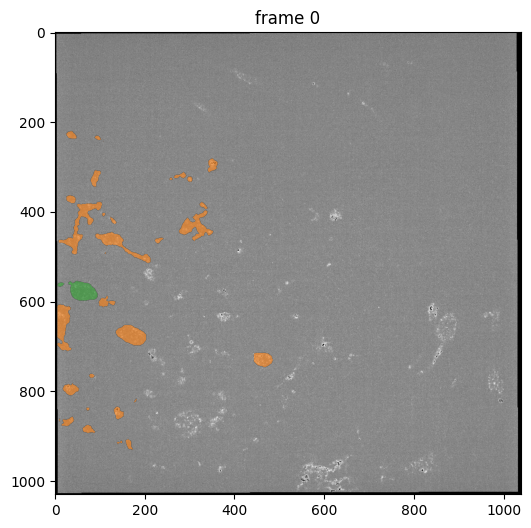

In [19]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id_list = [1,2,3,4]
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
ann_obj_id_2 = 2
ann_obj_id_3 = 3
ann_obj_id_4 = 4

import tifffile as tiff
mask_1 = tiff.imread('/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F017/Mask_labels/seg001/X10xX10h_TH_L3p3_b2z2_p20xw_F017_sT_seg001_Warping.labels_z1000.tif')
mask_2 = tiff.imread('/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F017/Mask_labels/seg002/X10xX10h_TH_L3p3_b2z2_p20xw_F017_sT_seg002_Warping.labels_z1000.tif')
mask_3 = tiff.imread('/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F017/Mask_labels/seg003/X10xX10h_TH_L3p3_b2z2_p20xw_F017_sT_seg003_Warping.labels_z1000.tif')
mask_4 = tiff.imread('/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F017/Mask_labels/seg004/X10xX10h_TH_L3p3_b2z2_p20xw_F017_sT_seg004_Warping.labels_z1000.tif')

# add new mask
_, out_obj_ids, out_mask_logits = predictor.add_new_mask(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    mask=mask_1,
)
_, out_obj_ids, out_mask_logits = predictor.add_new_mask(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id_2,
    mask=mask_2,
)

# _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id_3,
#     mask=mask_3,
# )

# _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id_4,
#     mask=mask_4,
# )

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])), cmap='gray')
for i, out_obj_id in enumerate(out_obj_ids):
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

Then, to get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video:   0%|          | 0/501 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 501/501 [00:22<00:00, 22.69it/s]


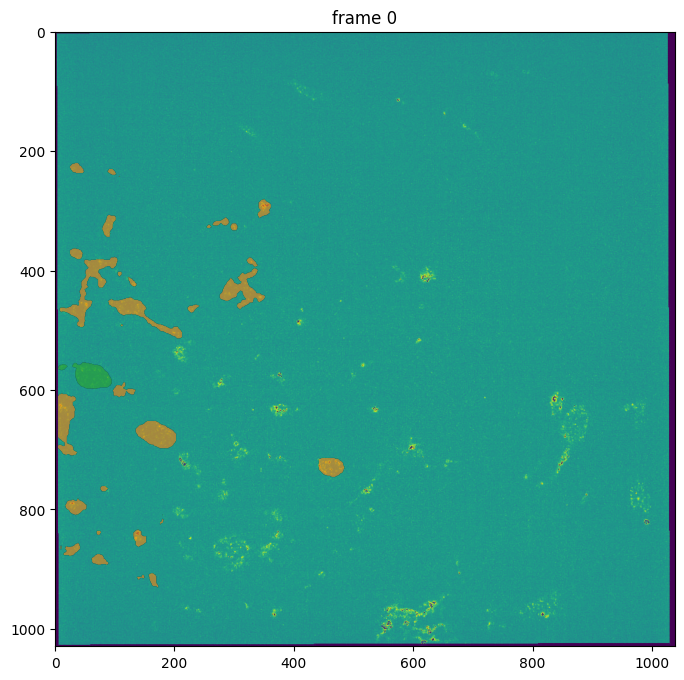

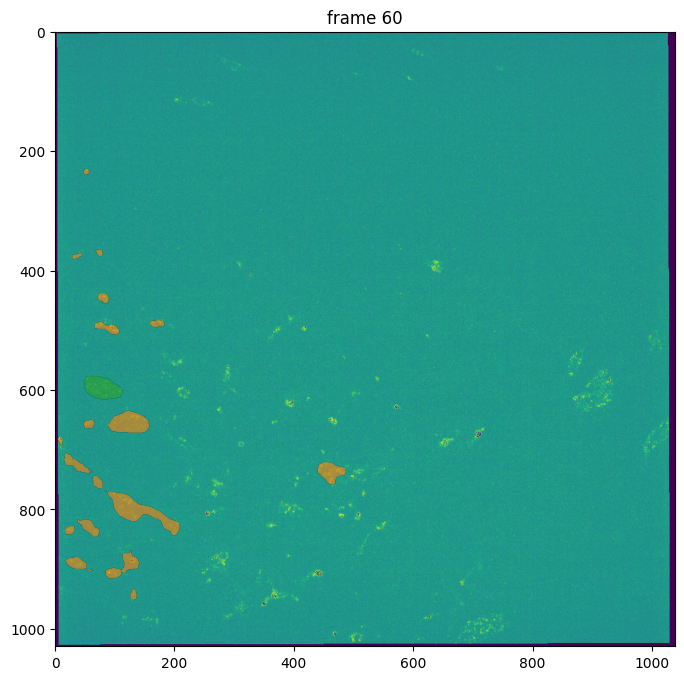

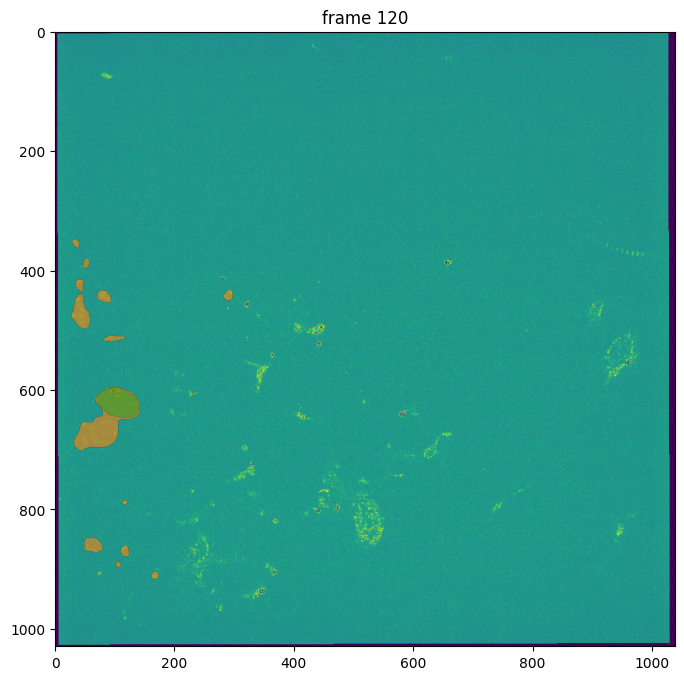

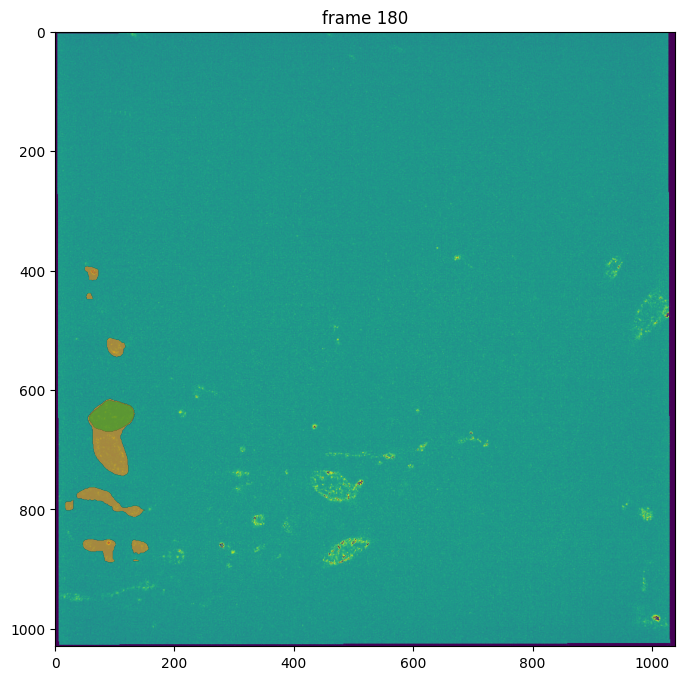

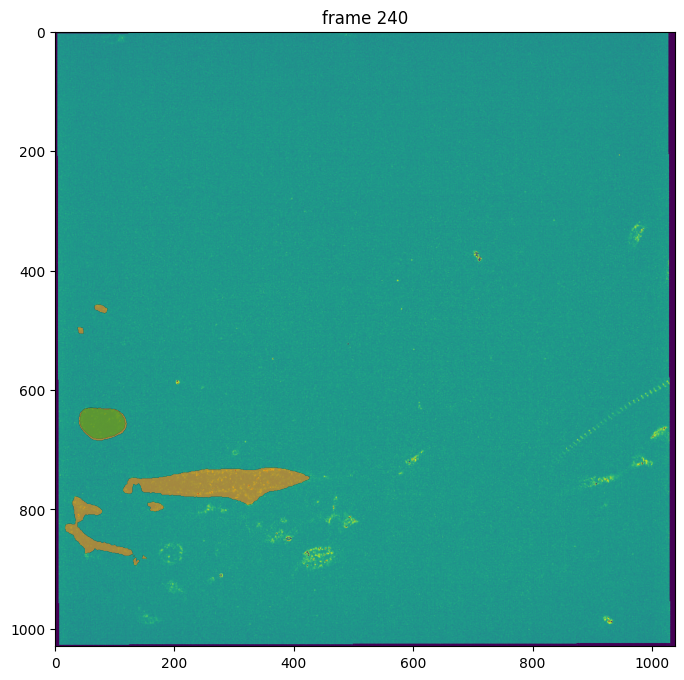

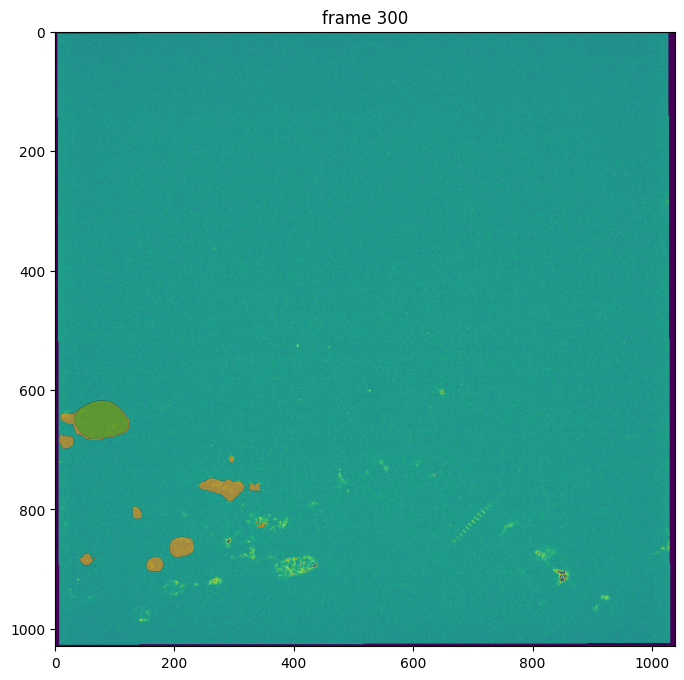

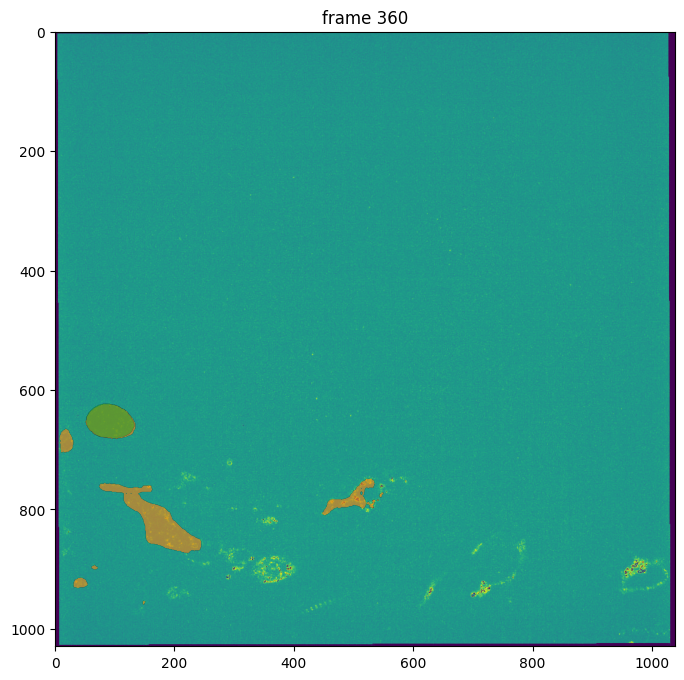

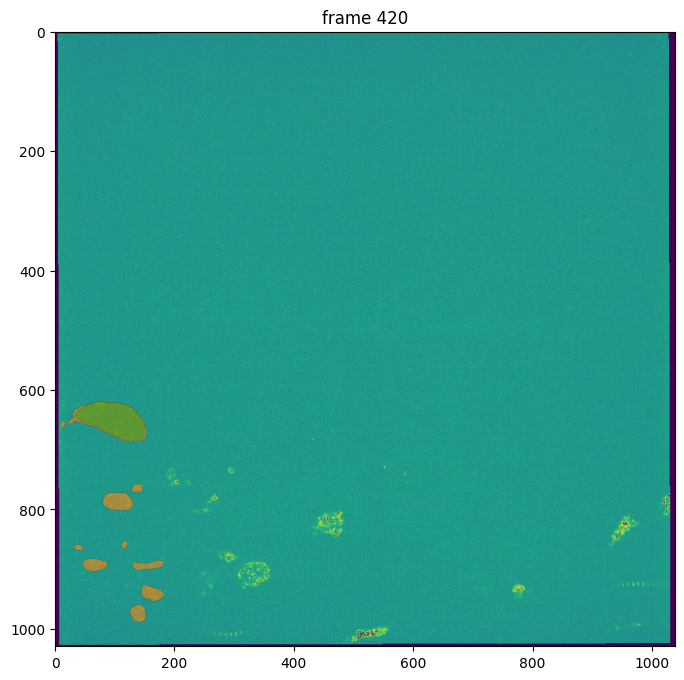

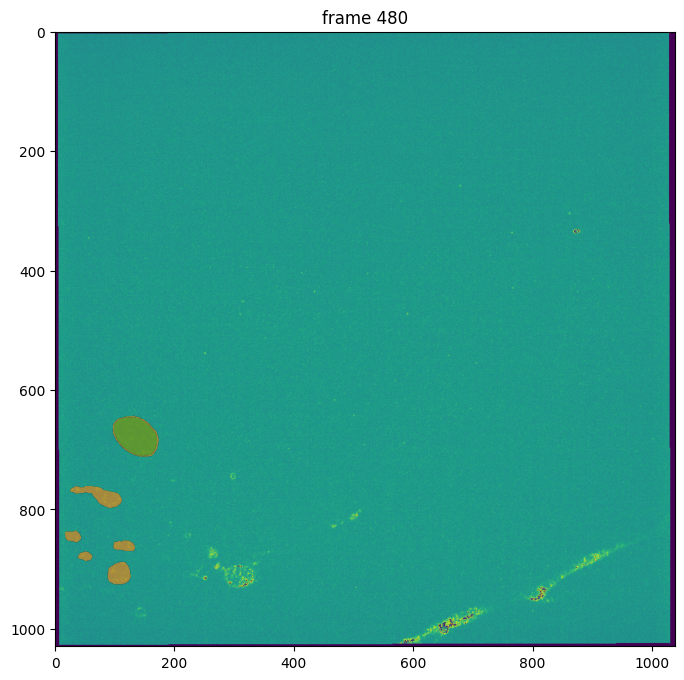

In [20]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 60
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(8, 8))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
# gt plot
# vis_frame_stride = 60
# plt.close("all")
# for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
#     plt.figure(figsize=(8, 8))
#     plt.title(f"frame {out_frame_idx}")
#     plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
#     for out_obj_id, out_mask in video_segments[out_frame_idx].items():
#         show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Note that in addition to clicks or boxes, SAM 2 also supports directly using a **mask prompt** as input via the `add_new_mask` method in the `SAM2VideoPredictor` class. This can be helpful in e.g. semi-supervised VOS evaluations (see [tools/vos_inference.py](https://github.com/facebookresearch/sam2/blob/main/tools/vos_inference.py) for an example).

### Get mask dice score

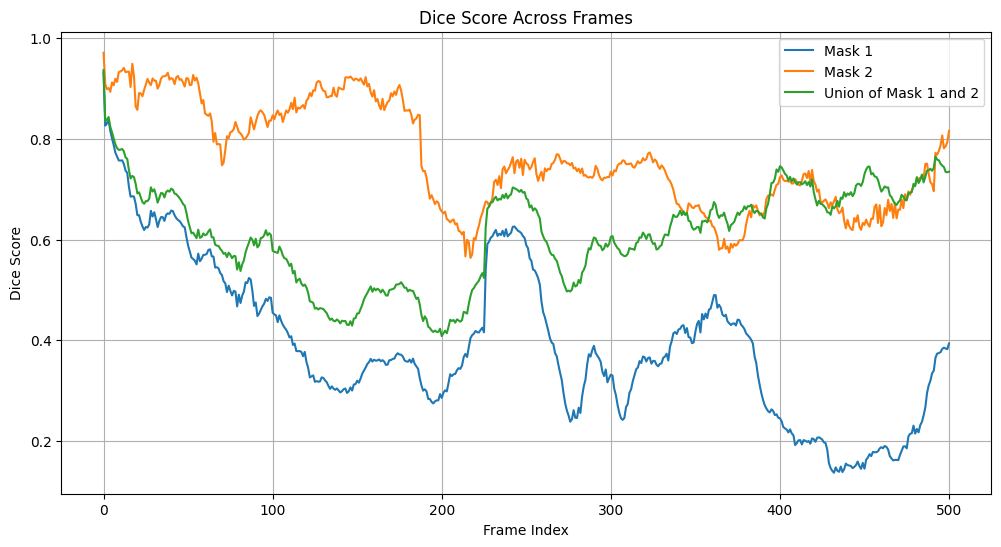

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from PIL import Image

def dice_score(pred_mask, true_mask):
    intersection = np.sum(pred_mask & true_mask)
    union = np.sum(pred_mask) + np.sum(true_mask)
    return 2 * intersection / union if union > 0 else 1.0

vis_frame_stride = 1

# video_segments = {  # Mocked; replace this with actual segmentation data
#     frame_idx: {4: np.random.rand(1, 1024, 1024) > 0.5, 5: np.random.rand(1, 1024, 1024) > 0.5}
#     for frame_idx in range(len(frame_names))
# }


dice_scores_mask_1 = []
dice_scores_mask_2 = []
dice_scores_union = []

for frame_idx in range(0, len(frame_names), vis_frame_stride):
    # pred_mask_1 = video_segments[frame_idx].get(4, np.zeros((1, 1024, 1024), dtype=bool))
    # pred_mask_2 = video_segments[frame_idx].get(5, np.zeros((1, 1024, 1024), dtype=bool))
    pred_mask_1 = video_segments[frame_idx][ann_obj_id]
    pred_mask_2 = video_segments[frame_idx][ann_obj_id_2]
    
    manual_mask_1_path = f"/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F017/Mask_labels/seg001/X10xX10h_TH_L3p3_b2z2_p20xw_F017_sT_seg001_Warping.labels_z{init_slice + frame_idx}.tif"
    manual_mask_2_path = f"/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F017/Mask_labels/seg002/X10xX10h_TH_L3p3_b2z2_p20xw_F017_sT_seg002_Warping.labels_z{init_slice + frame_idx}.tif"

    if os.path.exists(manual_mask_1_path) and os.path.exists(manual_mask_2_path):
        manual_mask_1 = tiff.imread(manual_mask_1_path).astype(bool)
        manual_mask_2 = tiff.imread(manual_mask_2_path).astype(bool)

        union_manual_mask = manual_mask_1 | manual_mask_2
        union_pred_mask = pred_mask_1[0] | pred_mask_2[0]

        dice_scores_mask_1.append(dice_score(pred_mask_1[0], manual_mask_1))
        dice_scores_mask_2.append(dice_score(pred_mask_2[0], manual_mask_2))
        dice_scores_union.append(dice_score(union_pred_mask, union_manual_mask))
    else:
        dice_scores_mask_1.append(0.0)
        dice_scores_mask_2.append(0.0)
        dice_scores_union.append(0.0)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(frame_names), vis_frame_stride), dice_scores_mask_1, label="Mask 1")
plt.plot(range(0, len(frame_names), vis_frame_stride), dice_scores_mask_2, label="Mask 2")
plt.plot(range(0, len(frame_names), vis_frame_stride), dice_scores_union, label="Union of Mask 1 and 2")
plt.xlabel("Frame Index")
plt.ylabel("Dice Score")
plt.title("Dice Score Across Frames")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# gt plot
vis_frame_stride = 60
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(8, 8))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [59]:
frame_idx = 0
manual_mask_1_path = f"/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F006/Mask_labels/seg001/X10xX10h_TH_L3p3_b2z2_p20xw_F006_sT_seg001.labels_z{1695 + frame_idx}.tif"
manual_mask_2_path = f"/homes/chunchieh/brain/data/20250110/X10xX10h_TH_L3p3_b2z2_p20xw_F006/Mask_labels/seg002/X10xX10h_TH_L3p3_b2z2_p20xw_F006_sT_seg002.labels_z0000_z{1695 + frame_idx}.tif"
manual_mask_1 = tiff.imread(manual_mask_1_path).astype(bool)
manual_mask_2 = tiff.imread(manual_mask_2_path).astype(bool)

union_manual_mask = manual_mask_1 | manual_mask_2
union_pred_mask = pred_mask_1[0] | pred_mask_2[0]

pred_mask_1 = video_segments[frame_idx][ann_obj_id]
pred_mask_2 = video_segments[frame_idx][ann_obj_id_2]


In [60]:
pred_mask_1

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [62]:
dice_score(pred_mask_1[0], manual_mask_1)

0.9355169869429919

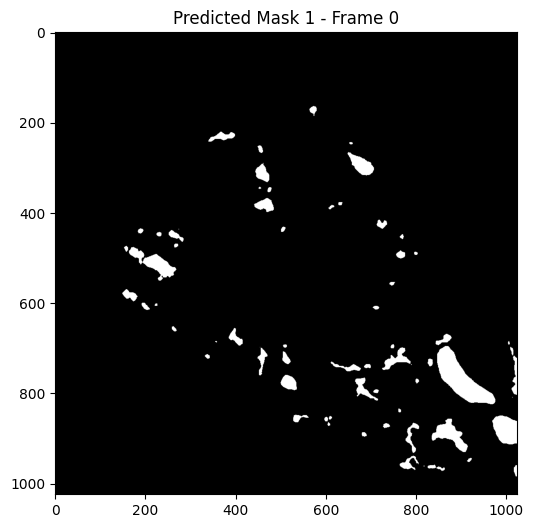

In [61]:
plt.figure(figsize=(6, 6))
plt.title(f"Predicted Mask 1 - Frame {frame_idx}")
plt.imshow(pred_mask_1[0], cmap='gray')
plt.show()

### Example 3: Segment multiple objects simultaneously

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [20]:
predictor.reset_state(inference_state)

#### Step 1: Add two objects on a frame

SAM 2 can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

This time, let's focus on object parts and segment **the shirts of both childen** in this video. Here we add prompts for these two objects and assign each of them a unique object id.

In [21]:
prompts = {}  # hold all the clicks we add for visualization

Add the first object (the left child's shirt) with a **positive click** at (x, y) = (200, 300) on frame 0.

We assign it to object id `2` (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the `add_new_points_or_box` API to distinguish the object we are clicking upon.

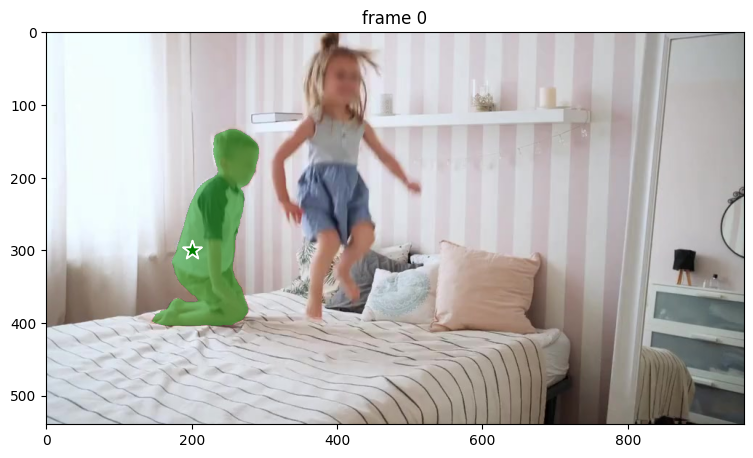

In [22]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[200, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

Hmm, this time we just want to select the child's shirt, but the model predicts the mask for the entire child. Let's refine the prediction with a **negative click** at (x, y) = (275, 175).

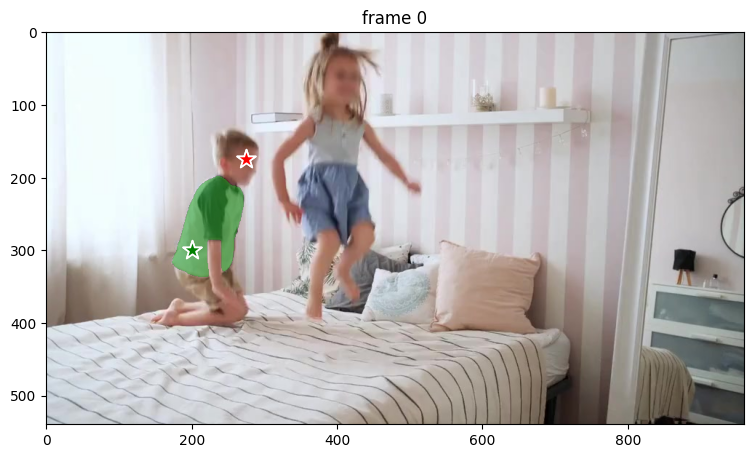

In [23]:
# add the first object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[200, 300], [275, 175]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

After the 2nd negative click, now we get the left child's shirt as our first object.

Let's move on to the second object (the right child's shirt) with a positive click at (x, y) = (400, 150) on frame 0. Here we assign object id `3` to this second object (it can be arbitrary integers, and only needs to be unique for each object to track).

Note: when there are multiple objects, the `add_new_points_or_box` API will return a list of masks for each object.

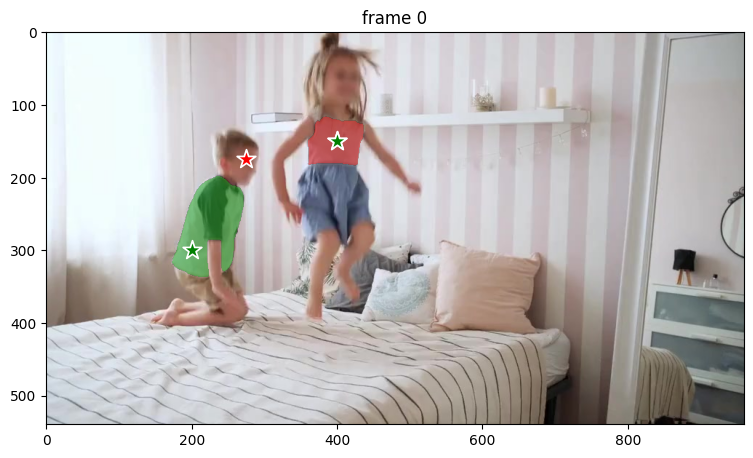

In [24]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[400, 150]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

This time the model predicts the mask of the shirt we want to track in just one click. Nice!

#### Step 2: Propagate the prompts to get masklets across the video

Now, we propagate the prompts for both objects to get their masklets throughout the video.

Note: when there are multiple objects, the `propagate_in_video` API will return a list of masks for each object.

propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.87it/s]


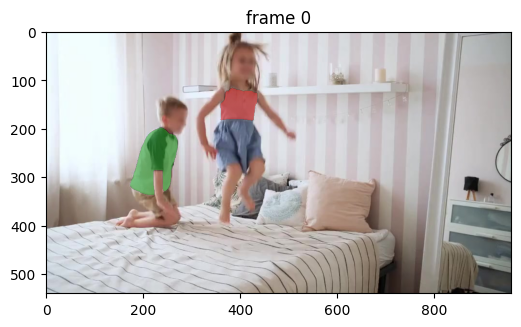

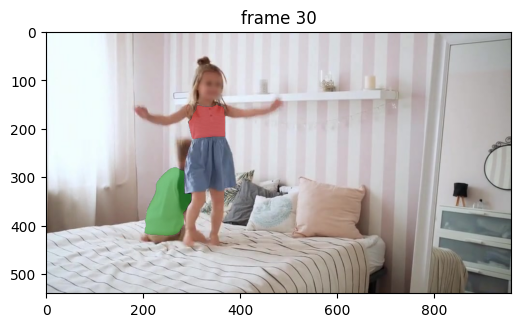

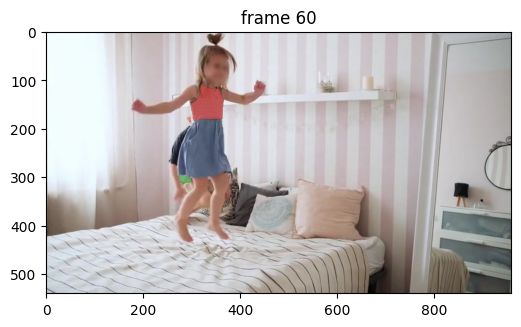

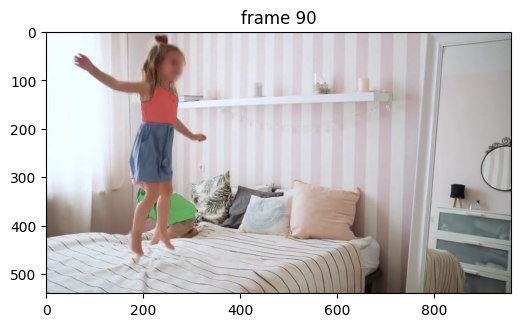

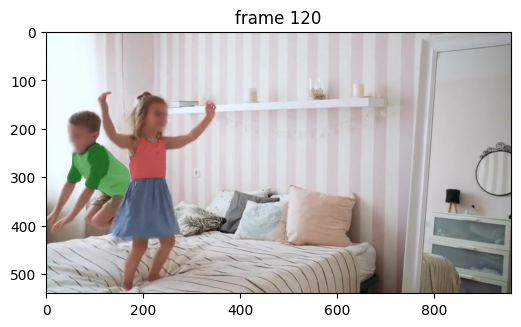

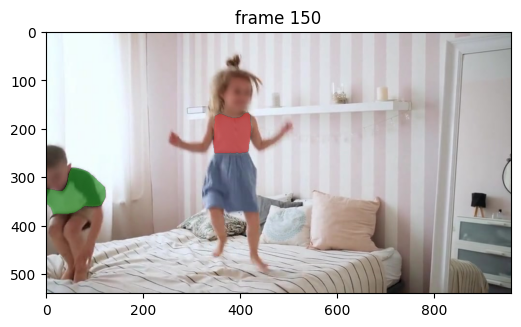

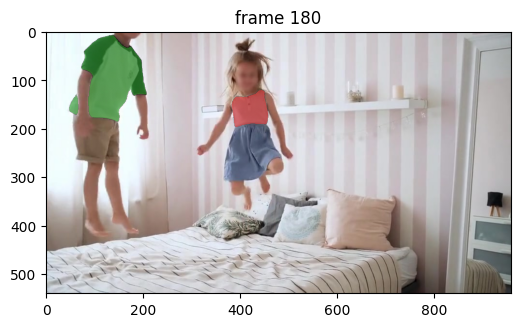

In [25]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Looks like both children's shirts are well segmented in this video.

Now you can try SAM 2 on your own videos and use cases! 